In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from src.process import BatchProcess, FedBatchProcess
from src.fed_batch_pinn import PINN, numpy_to_tensor, train
from src.utils import get_data_and_feed

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

__Parameter estimation using PINN__

In [2]:
FILENAME = '../data/data_processed.xlsx'
EXPERIMENT = 'BR01'

df, feeds = get_data_and_feed(FILENAME, EXPERIMENT)

t_fedbatch = df[df['Process'] == 'FB']['RTime'].min()
v_fedbatch = df[df['Process'] == 'FB']['V'].iloc[0]

print(f'Dataset shape: {df.shape}')

Dataset shape: (19, 8)


In [3]:
feeds

,Time,Duration,F,Induction
BR01,4.73,2.60,17.0,0
BR01,7.33,1.84,31.0,0
BR01,9.17,0.61,60.0,0
BR01,9.78,0.50,31.0,0


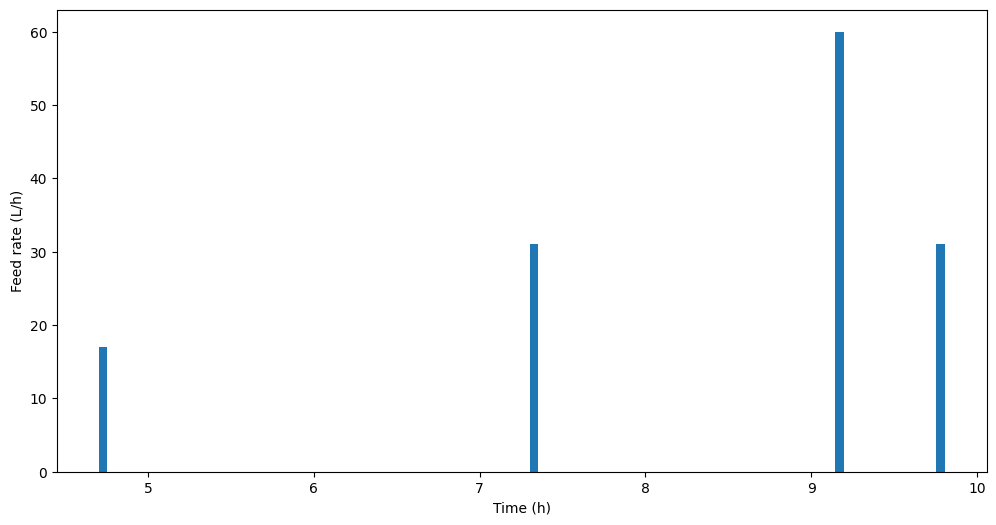

In [9]:
plt.figure(figsize=(12, 6))
plt.bar(feeds['Time'], feeds['F'], width=0.05)
plt.xlabel('Time (h)')
plt.ylabel('Feed rate (L/h)')
plt.show()

In [65]:
def plot_simulation(t, y, full_df, train_df, net_df, title):
    plt.figure(figsize=(10, 5))
    plt.plot(t, y[0], label='Biomass (ODE)', alpha=0.3)
    plt.plot(t, y[1], label='Glucose (ODE)', alpha=0.3)
    plt.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (All)', color='red', alpha=0.2)   
    plt.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (All)', color='green', alpha=0.2)
    plt.scatter(train_df['RTime'], train_df['Glucose'], label='Glucose (Train)', color='red', alpha=1)   
    plt.scatter(train_df['RTime'], train_df['Biomass'], label='Biomass (Train)', color='green', alpha=1)
    plt.scatter(net_df['RTime'], net_df['Glucose'], marker='+', label='Glucose (Predicted)', color='red', s=100, alpha=0.5)
    plt.scatter(net_df['RTime'], net_df['Biomass'], marker='+', label='Biomass (Predicted)', color='green', s=100, alpha=0.5)
    plt.legend()
    plt.title(f'Trained using {title} data points')
    plt.show()
 
def feeding_strategy(feeds: pd.DataFrame, time: float) -> float:
    for _, row in feeds.iterrows():
        start_time = row["Time"]
        end_time = row["Time"] + row["Duration"]
        if start_time <= time < end_time:
            return row["F"] / 1000
    return 0

def simulate(df, mu_max, Ks, Yxs):
    mu_max = mu_max
    Ks = Ks
    Yxs = Yxs
    
    def system_ode(t, y):
        X, S = y
        mu = mu_max * S / (Ks + S)
        dXdt = mu * X
        dSdt = - mu * X / Yxs
        return [dXdt, dSdt]
    
    t_eval = np.linspace(df['RTime'].min(), df['RTime'].max(), 10000)
    sol = solve_ivp(system_ode, [df['RTime'].min(), df['RTime'].max()], \
        [df['Biomass'].iloc[0], df['Glucose'].iloc[0]], t_eval=t_eval)
    return sol


Training using 2 data points


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


mu_max: 0.466422, Ks: 0.530353, Yxs: 0.5330


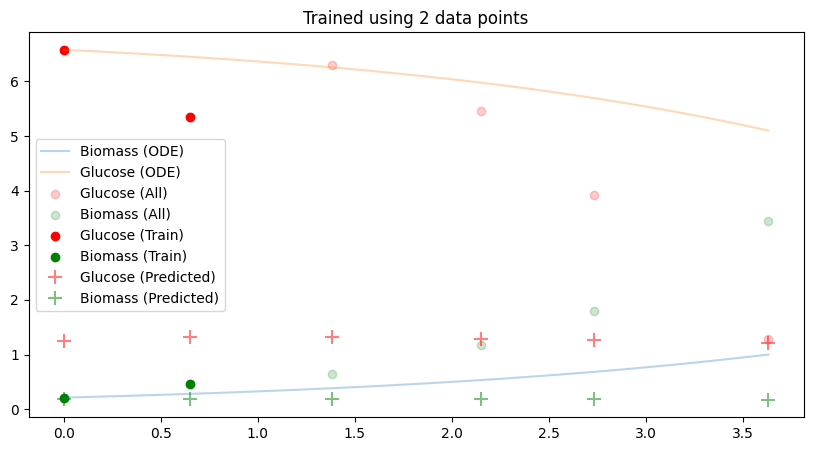

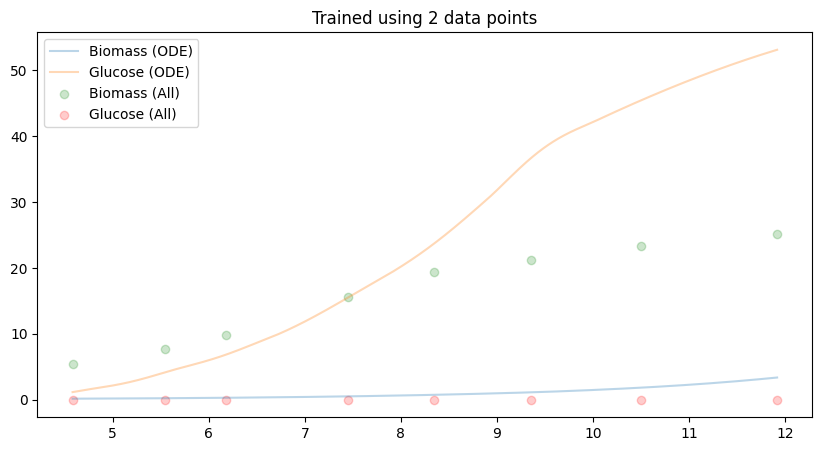

Training using 3 data points


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


mu_max: 0.461096, Ks: 0.536309, Yxs: 0.5386


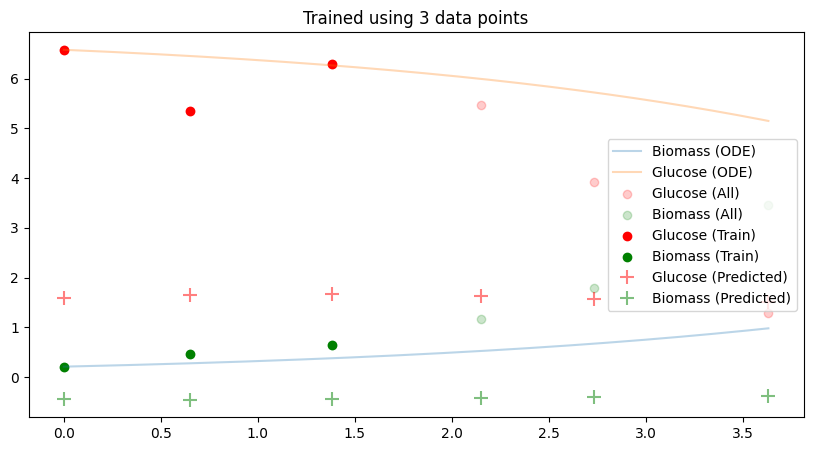

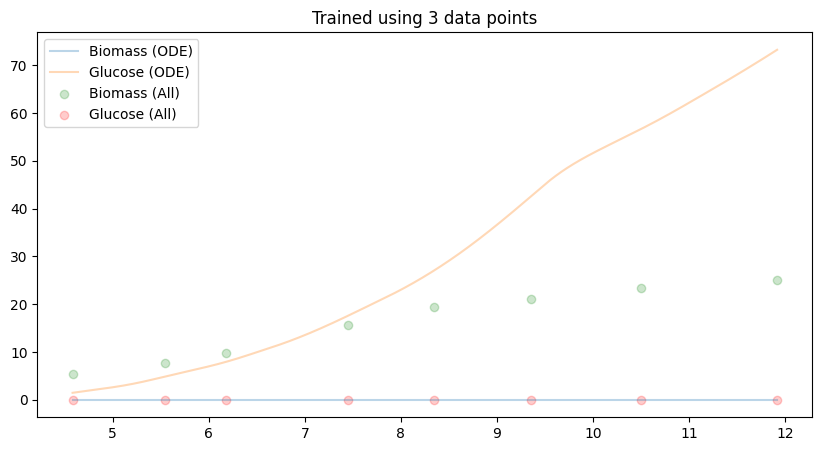

Training using 4 data points


 90%|█████████ | 9/10 [00:01<00:00,  5.75it/s]


KeyboardInterrupt: 

In [68]:
for i in range(2, len(df[df['Process'] == 'B'])+1):
    print(f'Training using {i} data points')
    
    _df = df.iloc[:i]
    _df = _df[_df['Process'] == 'B']
    t_start, t_end = _df['RTime'].min(), _df['RTime'].max()
    
    t = numpy_to_tensor(_df['RTime'].values)
    X = numpy_to_tensor(_df['Biomass'].values)
    S = numpy_to_tensor(_df['Glucose'].values)
    X_S = torch.cat((X, S), 1)
    
    # Define and Train PINN 
    net = PINN(1, 2, t_start=t_start, t_end=t_end)     
    net, total_loss, loss_data, loss_ic, loss_ode = train(net, t, X_S, df[df['Process'] == 'B'], num_epochs=10, verbose=False)

    # Store the results
    net_df = pd.DataFrame(columns=['RTime', 'Biomass', 'Glucose'])
    t_test = df[df['Process'] == 'B']['RTime'].values
    net_df['RTime'] = t_test
    t_test = numpy_to_tensor(t_test)
    net_df['Biomass'] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df['Glucose'] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    
    mu_max = net.mu_max.item()
    Ks = net.K_s.item()
    Yxs = net.Y_xs.item()
    
    print(f'mu_max: {mu_max:4f}, Ks: {Ks:4f}, Yxs: {Yxs:.4f}')
    
    solution = simulate(df[df['Process'] == 'B'], mu_max, Ks, Yxs)
    plot_simulation(solution.t, solution.y, df[df['Process'] == 'B'], _df, net_df, title=i)
    
    _df = df[df['Process'] == 'FB']

    t_start, t_end = _df['RTime'].min(), _df['RTime'].max()
    X0_pred, S0_pred = net.forward(numpy_to_tensor(np.array([t_fedbatch]))).detach().cpu().numpy()[0]
    
    S0_pred = max(S0_pred, 0.01)
    
    def fed_batch_system_ode(t, y):
        X, S, V = y
        
        Sin = 1.43 * 200
        mu_max = net.mu_max.item()
        Ks = net.K_s.item()
        Yxs = net.Y_xs.item()
        
        mu = mu_max * S / (Ks + S)
        q_s = mu / Yxs
        
        F = feeding_strategy(feeds, t)
        
        dVdt = F
        dXdt = mu * X - X * F / V
        dSdt = - q_s * X + (Sin - S) * F / V
        
        return [dXdt, dSdt, dVdt]

    y0 = [X0_pred, S0_pred, v_fedbatch]

    t_span = (t_start, t_end)
    t_eval = np.linspace(t_span[0], t_span[1], 1000)
    solution = solve_ivp(fed_batch_system_ode, t_span, y0, t_eval=t_eval)
    
    solution.y[0][solution.y[0] < 0] = 0
    solution.y[1][solution.y[1] < 0] = 0
    solution.y[2][solution.y[2] < 0] = 0

    plt.figure(figsize=(10, 5))
    plt.plot(solution.t, solution.y[0], label='Biomass (ODE)', alpha=0.3)
    plt.plot(solution.t, solution.y[1], label='Glucose (ODE)', alpha=0.3)
    plt.scatter(_df['RTime'], _df['Biomass'], label='Biomass (All)', color='green', alpha=0.2)
    plt.scatter(_df['RTime'], _df['Glucose'], label='Glucose (All)', color='red', alpha=0.2)
    plt.legend()
    plt.title(f'Trained using {i} data points')
    plt.show()